In [1]:
import pandas as pd

In [2]:
import yfinance as yf

# Data Preparation

In [4]:
start_date = "2022-01-01"
end_date = "2024-12-31"
tickers = ["NKE", "ADDYY"]
window = 90

In [5]:
def storing_inputs(start_date, end_date, tickers):
    # Define the start and end dates (yyyy-mm-dd)
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # Calculate the difference in months
    months_diff = (end_date.year - start_date.year) * 12 + end_date.month - start_date.month

    stock_data = yf.download(tickers, start=start_date, end=end_date)

    # Extract only the closing prices
    closing_prices = stock_data['Close']
    
    return closing_prices

In [6]:
# Correct way to call the function and store results
closing_prices = storing_inputs(start_date, end_date, tickers)

[*********************100%***********************]  2 of 2 completed


In [7]:
closing_prices.head()

Ticker,ADDYY,NKE
Date,,
2022-01-03 00:00:00+00:00,147.149994,164.669998
2022-01-04 00:00:00+00:00,146.050003,166.389999
2022-01-05 00:00:00+00:00,145.289993,162.250000
2022-01-06 00:00:00+00:00,142.929993,161.039993
2022-01-07 00:00:00+00:00,140.830002,156.970001


In [8]:
type(closing_prices.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [9]:
closing_prices_changes = closing_prices.pct_change().dropna()

## Checking linear relationship

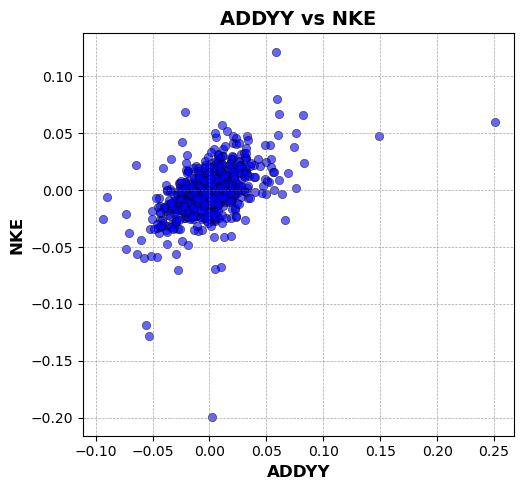

In [11]:
import matplotlib.pyplot as plt

# Use a clean theme with a white background
plt.style.use('default')

# Create the figure
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 3)

first_col_name = closing_prices_changes.columns[0]
second_col_name = closing_prices_changes.columns[1]


# Pairs
scatter = ax.scatter(
    closing_prices_changes[first_col_name], 
    closing_prices_changes[second_col_name], 
    color='blue', 
    edgecolor='black',  # Add black borders to the points
    alpha=0.6,          # Transparency for points
    linewidth=0.5       # Thickness of the borders
)

# Labels and title
ax.set_xlabel(first_col_name, fontsize=12, weight='bold')
ax.set_ylabel(second_col_name, fontsize=12, weight='bold')
ax.set_title(f"{first_col_name} vs {second_col_name}", fontsize=14, weight='bold')

# Add gridlines
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize ticks
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)



# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

## Cointegration

Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression.

In [14]:
# Import the statsmodels module for regression and the adfuller function
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 
from statsmodels.tsa.stattools import adfuller

Without add_constant(), the regression assumes no intercept <br/>
Intercept provides better model fit (unless you know the true relationship has no intercept).

`smf.ols(formula, data)` : Automatically includes an intercept.

In [17]:
model = smf.ols(formula='ADDYY ~ NKE', data=closing_prices_changes)
result = model.fit()

In [18]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  ADDYY   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     249.3
Date:                Sun, 02 Feb 2025   Prob (F-statistic):           1.08e-48
Time:                        17:19:11   Log-Likelihood:                 1801.7
No. Observations:                 751   AIC:                            -3599.
Df Residuals:                     749   BIC:                            -3590.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.001      0.680      0.4

In [19]:
# Extract the coefficient (beta)
beta_sec = result.params[second_col_name]
print(f"Beta: {beta_sec}")

Beta: 0.5862071033078231


In [20]:
r_squared = result.rsquared

In [42]:
# Dynamically print the summary 
print("\033[1mSummary of Key Takeaways:\033[0m\n")

print(f"Model Significance: The model is statistically significant with an extremely low p-value for the F-statistic and {second_col_name}'s coefficient.\n")
print(f"Relationship Strength: {second_col_name} explains {r_squared*100: .0f}% of the variation in {first_col_name}, which is moderate.\n")
print(f"Effect of {second_col_name} on {first_col_name}: A 1-unit increase in {second_col_name} is associated with a {beta_sec:.2f} increase in {first_col_name}.\n")
print(f"Residuals: The residuals are not perfectly normal, which might suggest non-constant variance or outliers affecting the model.\n")


Summary of Key Takeaways:

Model Significance: The model is statistically significant with an extremely low p-value for the F-statistic and NKE's coefficient.

Relationship Strength: NKE explains  25% of the variation in ADDYY, which is moderate.

Effect of NKE on ADDYY: A 1-unit increase in NKE is associated with a 0.59 increase in ADDYY.

Residuals: The residuals are not perfectly normal, which might suggest non-constant variance or outliers affecting the model.



In [44]:
# Compute ADF
b = result.params[second_col_name]
adf_stats = adfuller(closing_prices_changes[first_col_name] - b*closing_prices_changes[second_col_name])
print(f"The p-value for the ADF test is {adf_stats[1]:.3f}")

The p-value for the ADF test is 0.000


In [68]:
# Compute the cointegration residuals
# df_coint = closing_prices_changes[first_col_name] - b * closing_prices_changes[second_col_name]
df_coint = result.resid

df_coint.head()

Date
2022-01-04 00:00:00+00:00   -0.014145
2022-01-05 00:00:00+00:00    0.008835
2022-01-06 00:00:00+00:00   -0.012418
2022-01-07 00:00:00+00:00   -0.000424
2022-01-10 00:00:00+00:00    0.027887
dtype: float64

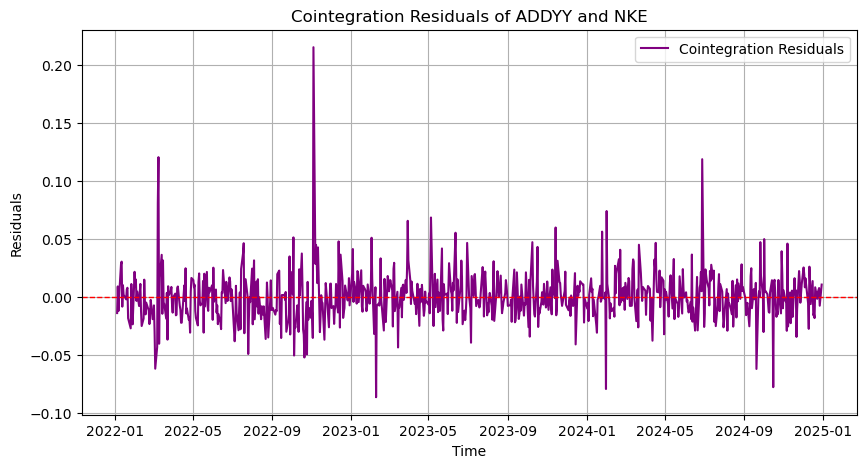

In [70]:
# Plot the time series of residuals
plt.figure(figsize=(10,5))

plt.plot(df_coint, label="Cointegration Residuals", color='purple')

plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Zero mean line
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title(f"Cointegration Residuals of {first_col_name} and {second_col_name}")

plt.legend()
plt.grid()

plt.show()

In [76]:
import numpy as np

In [78]:
# Calculate the percentiles of residuals
lower_percentile = np.percentile(df_coint, 5)  # 5th percentile
upper_percentile = np.percentile(df_coint, 95)  # 95th percentile

In [84]:
print(f"{lower_percentile:.2f}, {upper_percentile:.2f}")

-0.03, 0.03


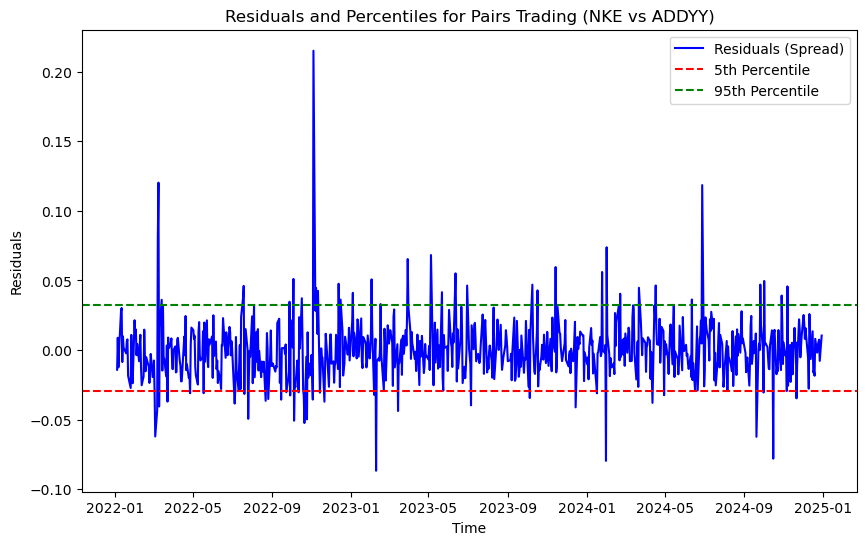

In [90]:
#Visualize the residuals and percentiles
plt.figure(figsize=(10,6))
plt.plot(df_coint, label='Residuals (Spread)', color='blue')
plt.axhline(y=lower_percentile, color='red', linestyle='--', label='5th Percentile')
plt.axhline(y=upper_percentile, color='green', linestyle='--', label='95th Percentile')
plt.title('Residuals and Percentiles for Pairs Trading (NKE vs ADDYY)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()